## 03/03/2021

Model optimisation should be done on the autoencoder model to find out which parameter had the strongest performances
this is the same as the autoencoder model, but with a larger latent space

This has the effect of allowing the autoencoder to extract more features from the input spectrograms.

This may be good as it could be missing out on some important features previously, so that this would then allow the model to capture these previously missed features. 


alternatively, it could also mean that more noise is captured and the model confuses itself. 

There should be a sweet spot for the size ofthe latent space. 

Resulted in much weaker performance than previous model. try a smaller latent space. 



In [1]:
import torch 
import json 
import numpy as np 
from sklearn.model_selection import train_test_split 
from torch.utils.data import SubsetRandomSampler, DataLoader,TensorDataset
from tqdm import tqdm 
import torch.nn.functional as F
from torch import nn


In [2]:
DATA_PATH = "./data/synthetic/train_data.json"
TEST_PATH = "./data/synthetic/test_data.json"
EPOCHS = 300
BATCH_SIZE = 150
SAVED_MODEL_PATH = "./models/model2.pth"

In [6]:
def load_dataset(data_path):
    with open(data_path,"r") as fp: 
        data = json.load(fp)
    X = np.array(data["data"])
    y = np.array(data["labels"])
    return X, y 

def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device)for x in data]
    else:
        return data.to(device, non_blocking = True)
    
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl 
        self.device = device 
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)
    
    
X,y=load_dataset(DATA_PATH)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
dataset = TensorDataset(X,y)
X_test, y_test = load_dataset(TEST_PATH)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
testset = TensorDataset(X_test,y_test)

train_dl = DataLoader(dataset, BATCH_SIZE, shuffle = True, drop_last=True)
test_dl = DataLoader(testset, BATCH_SIZE, shuffle = True, drop_last=True)

input_shape = dataset[0][0].shape
device = torch.device('cuda')
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [7]:
print(testset[0][0].shape)
print(type(dataset[0][0]))

torch.Size([1, 128, 16])
<class 'torch.Tensor'>


In [8]:
latent_size = 14 
# https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,stride = 2, padding=1 , kernel_size=3)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(32,64, stride = 2, padding =1, kernel_size=3)
        self.conv3 = nn.Conv2d(64,128,stride =2, padding =1, kernel_size = 3)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4096,latent_size)
        self.fc = nn.Linear(latent_size,4096)
        self.deconv3 = nn.ConvTranspose2d(128,64,stride =2, kernel_size = 3, padding =1,output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64,32,stride =2, kernel_size = 3,padding =1,output_padding=1)
        self.deconv1 = nn.ConvTranspose2d(32,1,stride =2, kernel_size = 3,padding =1,output_padding=1)
    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)        
        out = self.relu(out)
        out = self.flatten(out)
        out = self.linear(out)
        out = self.relu(out)
        out = self.fc(out)
        out = self.relu(out)
        out = out.reshape(-1,128,16,2)
        out = self.deconv3(out)
        out = self.relu(out)
        out = self.deconv2(out)
        out = self.relu(out)
        out = self.deconv1(out)
        return out
autoencoder = Autoencoder()
autoencoder.to(device)
#autoencoder.load_state_dict(torch.load(SAVED_MODEL_PATH))

Autoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu): LeakyReLU(negative_slope=0.2)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=4096, out_features=14, bias=True)
  (fc): Linear(in_features=14, out_features=4096, bias=True)
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv1): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

In [9]:
from torchsummary import summary 
summary(autoencoder, input_size = (1,128,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 32, 64, 8]             320
         LeakyReLU-2            [-1, 32, 64, 8]               0
            Conv2d-3            [-1, 64, 32, 4]          18,496
         LeakyReLU-4            [-1, 64, 32, 4]               0
            Conv2d-5           [-1, 128, 16, 2]          73,856
         LeakyReLU-6           [-1, 128, 16, 2]               0
           Flatten-7                 [-1, 4096]               0
            Linear-8                   [-1, 14]          57,358
         LeakyReLU-9                   [-1, 14]               0
           Linear-10                 [-1, 4096]          61,440
        LeakyReLU-11                 [-1, 4096]               0
  ConvTranspose2d-12            [-1, 64, 32, 4]          73,792
        LeakyReLU-13            [-1, 64, 32, 4]               0
  ConvTranspose2d-14            [-1, 32

In [10]:

for images, labels in test_dl: 
    print("spectrogram shape: ", images.shape)
    out = autoencoder(images)
    
    print("output shape: ", out.shape)
    break 
    
img = out[0][0].detach().cpu()
print(img.shape)
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(1,1,figsize = (5,5))
ax.imshow(img, aspect = 'auto')


spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 1, 128, 16])
torch.Size([128, 16])


## Now start training and see what the resulting image would look like 


In [11]:
criterion = nn.MSELoss()
ae_opt= torch.optim.Adam(autoencoder.parameters(), lr = 0.0002)


In [12]:
loss_list = []
EPOCHS = 5000
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_dl):
        reconstructed = autoencoder(images)
        loss = criterion(images, reconstructed)
        
        ae_opt.zero_grad()
        loss.backward()
        ae_opt.step()
    
    loss_list.append(np.sum(loss.item()))
    
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, EPOCHS, loss.item()))

        


epoch [1/5000], loss:140.9702
epoch [2/5000], loss:125.6247
epoch [3/5000], loss:90.3700
epoch [4/5000], loss:79.4672
epoch [5/5000], loss:68.0678
epoch [6/5000], loss:61.1283
epoch [7/5000], loss:62.3221
epoch [8/5000], loss:58.1306
epoch [9/5000], loss:55.7412
epoch [10/5000], loss:55.4911
epoch [11/5000], loss:57.2207
epoch [12/5000], loss:55.1226
epoch [13/5000], loss:52.9216
epoch [14/5000], loss:51.2347
epoch [15/5000], loss:59.1419
epoch [16/5000], loss:55.5601
epoch [17/5000], loss:50.4510
epoch [18/5000], loss:53.0118
epoch [19/5000], loss:56.0134
epoch [20/5000], loss:54.8454
epoch [21/5000], loss:54.5347
epoch [22/5000], loss:53.4212
epoch [23/5000], loss:53.0009
epoch [24/5000], loss:52.4036
epoch [25/5000], loss:56.3475
epoch [26/5000], loss:60.2347
epoch [27/5000], loss:48.7110
epoch [28/5000], loss:52.7812
epoch [29/5000], loss:51.7252
epoch [30/5000], loss:48.4468
epoch [31/5000], loss:54.0435
epoch [32/5000], loss:56.1093
epoch [33/5000], loss:48.6188
epoch [34/5000], 

epoch [269/5000], loss:29.3193
epoch [270/5000], loss:29.0228
epoch [271/5000], loss:29.1044
epoch [272/5000], loss:29.7910
epoch [273/5000], loss:29.0256
epoch [274/5000], loss:29.1912
epoch [275/5000], loss:29.3022
epoch [276/5000], loss:29.1575
epoch [277/5000], loss:29.2182
epoch [278/5000], loss:29.0249
epoch [279/5000], loss:29.2641
epoch [280/5000], loss:28.9929
epoch [281/5000], loss:29.0666
epoch [282/5000], loss:29.4289
epoch [283/5000], loss:29.2493
epoch [284/5000], loss:29.5084
epoch [285/5000], loss:29.1703
epoch [286/5000], loss:29.1033
epoch [287/5000], loss:29.6664
epoch [288/5000], loss:28.9755
epoch [289/5000], loss:29.2656
epoch [290/5000], loss:29.1745
epoch [291/5000], loss:29.5395
epoch [292/5000], loss:29.2534
epoch [293/5000], loss:29.1022
epoch [294/5000], loss:29.3788
epoch [295/5000], loss:29.1236
epoch [296/5000], loss:29.1567
epoch [297/5000], loss:29.2532
epoch [298/5000], loss:29.1087
epoch [299/5000], loss:29.1438
epoch [300/5000], loss:29.5647
epoch [3

epoch [534/5000], loss:28.5621
epoch [535/5000], loss:28.2812
epoch [536/5000], loss:28.4558
epoch [537/5000], loss:28.2692
epoch [538/5000], loss:27.9760
epoch [539/5000], loss:27.9158
epoch [540/5000], loss:28.2468
epoch [541/5000], loss:28.1382
epoch [542/5000], loss:28.5914
epoch [543/5000], loss:28.0037
epoch [544/5000], loss:28.1363
epoch [545/5000], loss:28.1633
epoch [546/5000], loss:28.1903
epoch [547/5000], loss:28.2807
epoch [548/5000], loss:28.3189
epoch [549/5000], loss:27.9864
epoch [550/5000], loss:27.8371
epoch [551/5000], loss:28.1641
epoch [552/5000], loss:27.7262
epoch [553/5000], loss:28.0943
epoch [554/5000], loss:28.5438
epoch [555/5000], loss:28.3535
epoch [556/5000], loss:27.9528
epoch [557/5000], loss:27.8549
epoch [558/5000], loss:28.2818
epoch [559/5000], loss:28.1626
epoch [560/5000], loss:28.1760
epoch [561/5000], loss:28.2738
epoch [562/5000], loss:28.1384
epoch [563/5000], loss:28.2992
epoch [564/5000], loss:28.2850
epoch [565/5000], loss:28.3774
epoch [5

epoch [799/5000], loss:27.1793
epoch [800/5000], loss:27.5065
epoch [801/5000], loss:27.6016
epoch [802/5000], loss:27.7243
epoch [803/5000], loss:27.7439
epoch [804/5000], loss:27.4139
epoch [805/5000], loss:27.3446
epoch [806/5000], loss:27.3955
epoch [807/5000], loss:27.5930
epoch [808/5000], loss:27.4580
epoch [809/5000], loss:27.2327
epoch [810/5000], loss:27.5780
epoch [811/5000], loss:27.5290
epoch [812/5000], loss:27.6677
epoch [813/5000], loss:27.3550
epoch [814/5000], loss:27.3244
epoch [815/5000], loss:27.4704
epoch [816/5000], loss:27.2360
epoch [817/5000], loss:27.7246
epoch [818/5000], loss:27.4931
epoch [819/5000], loss:27.3759
epoch [820/5000], loss:27.3505
epoch [821/5000], loss:27.2279
epoch [822/5000], loss:27.6484
epoch [823/5000], loss:27.4276
epoch [824/5000], loss:27.6573
epoch [825/5000], loss:27.2832
epoch [826/5000], loss:27.2819
epoch [827/5000], loss:27.0093
epoch [828/5000], loss:27.5257
epoch [829/5000], loss:27.5648
epoch [830/5000], loss:27.8727
epoch [8

epoch [1062/5000], loss:26.8374
epoch [1063/5000], loss:26.6594
epoch [1064/5000], loss:26.6879
epoch [1065/5000], loss:26.9974
epoch [1066/5000], loss:27.2566
epoch [1067/5000], loss:26.9176
epoch [1068/5000], loss:26.7109
epoch [1069/5000], loss:26.7584
epoch [1070/5000], loss:26.9416
epoch [1071/5000], loss:27.0864
epoch [1072/5000], loss:27.2310
epoch [1073/5000], loss:26.8240
epoch [1074/5000], loss:26.7052
epoch [1075/5000], loss:26.9568
epoch [1076/5000], loss:26.5859
epoch [1077/5000], loss:26.5609
epoch [1078/5000], loss:26.7112
epoch [1079/5000], loss:26.8368
epoch [1080/5000], loss:26.8684
epoch [1081/5000], loss:26.8096
epoch [1082/5000], loss:27.1788
epoch [1083/5000], loss:27.0943
epoch [1084/5000], loss:26.8008
epoch [1085/5000], loss:26.8657
epoch [1086/5000], loss:27.2134
epoch [1087/5000], loss:27.1596
epoch [1088/5000], loss:27.1385
epoch [1089/5000], loss:27.0270
epoch [1090/5000], loss:26.8366
epoch [1091/5000], loss:26.8316
epoch [1092/5000], loss:26.7811
epoch [1

epoch [1319/5000], loss:26.5831
epoch [1320/5000], loss:26.5467
epoch [1321/5000], loss:26.4110
epoch [1322/5000], loss:26.5751
epoch [1323/5000], loss:26.6858
epoch [1324/5000], loss:26.5833
epoch [1325/5000], loss:26.2206
epoch [1326/5000], loss:26.6271
epoch [1327/5000], loss:26.2986
epoch [1328/5000], loss:26.7757
epoch [1329/5000], loss:26.5831
epoch [1330/5000], loss:26.3514
epoch [1331/5000], loss:26.6367
epoch [1332/5000], loss:26.3897
epoch [1333/5000], loss:26.4791
epoch [1334/5000], loss:26.1471
epoch [1335/5000], loss:26.7471
epoch [1336/5000], loss:26.3795
epoch [1337/5000], loss:26.6686
epoch [1338/5000], loss:26.8379
epoch [1339/5000], loss:26.3636
epoch [1340/5000], loss:26.6332
epoch [1341/5000], loss:26.3544
epoch [1342/5000], loss:26.6097
epoch [1343/5000], loss:26.3387
epoch [1344/5000], loss:26.2803
epoch [1345/5000], loss:26.6257
epoch [1346/5000], loss:26.2877
epoch [1347/5000], loss:26.4135
epoch [1348/5000], loss:26.2475
epoch [1349/5000], loss:26.1498
epoch [1

epoch [1576/5000], loss:25.8734
epoch [1577/5000], loss:26.5000
epoch [1578/5000], loss:26.2761
epoch [1579/5000], loss:26.1859
epoch [1580/5000], loss:26.1683
epoch [1581/5000], loss:26.3486
epoch [1582/5000], loss:25.9593
epoch [1583/5000], loss:26.1232
epoch [1584/5000], loss:25.9432
epoch [1585/5000], loss:26.0508
epoch [1586/5000], loss:26.1208
epoch [1587/5000], loss:26.0935
epoch [1588/5000], loss:25.9403
epoch [1589/5000], loss:26.2680
epoch [1590/5000], loss:26.2527
epoch [1591/5000], loss:26.5456
epoch [1592/5000], loss:25.7362
epoch [1593/5000], loss:26.3286
epoch [1594/5000], loss:25.9269
epoch [1595/5000], loss:26.2250
epoch [1596/5000], loss:26.1050
epoch [1597/5000], loss:26.2551
epoch [1598/5000], loss:26.2631
epoch [1599/5000], loss:25.9889
epoch [1600/5000], loss:26.1656
epoch [1601/5000], loss:26.1297
epoch [1602/5000], loss:26.0828
epoch [1603/5000], loss:25.6825
epoch [1604/5000], loss:26.1100
epoch [1605/5000], loss:26.1720
epoch [1606/5000], loss:26.3654
epoch [1

epoch [1833/5000], loss:25.8253
epoch [1834/5000], loss:26.2730
epoch [1835/5000], loss:26.0168
epoch [1836/5000], loss:25.9454
epoch [1837/5000], loss:25.8063
epoch [1838/5000], loss:25.9217
epoch [1839/5000], loss:25.7642
epoch [1840/5000], loss:25.9138
epoch [1841/5000], loss:25.5412
epoch [1842/5000], loss:25.9310
epoch [1843/5000], loss:26.0494
epoch [1844/5000], loss:26.0775
epoch [1845/5000], loss:26.1832
epoch [1846/5000], loss:25.6716
epoch [1847/5000], loss:25.8257
epoch [1848/5000], loss:26.0082
epoch [1849/5000], loss:25.7556
epoch [1850/5000], loss:25.8642
epoch [1851/5000], loss:25.7597
epoch [1852/5000], loss:25.7361
epoch [1853/5000], loss:25.8749
epoch [1854/5000], loss:25.8804
epoch [1855/5000], loss:25.6946
epoch [1856/5000], loss:25.1932
epoch [1857/5000], loss:25.3948
epoch [1858/5000], loss:25.9899
epoch [1859/5000], loss:25.9086
epoch [1860/5000], loss:25.8312
epoch [1861/5000], loss:25.5695
epoch [1862/5000], loss:25.8429
epoch [1863/5000], loss:25.7681
epoch [1

epoch [2090/5000], loss:25.3543
epoch [2091/5000], loss:26.0711
epoch [2092/5000], loss:26.0094
epoch [2093/5000], loss:25.2805
epoch [2094/5000], loss:25.8895
epoch [2095/5000], loss:25.6566
epoch [2096/5000], loss:25.6089
epoch [2097/5000], loss:25.2558
epoch [2098/5000], loss:25.6718
epoch [2099/5000], loss:25.6400
epoch [2100/5000], loss:25.1990
epoch [2101/5000], loss:25.6566
epoch [2102/5000], loss:25.3083
epoch [2103/5000], loss:25.0289
epoch [2104/5000], loss:25.7161
epoch [2105/5000], loss:25.9848
epoch [2106/5000], loss:25.7782
epoch [2107/5000], loss:25.6267
epoch [2108/5000], loss:25.3785
epoch [2109/5000], loss:25.3674
epoch [2110/5000], loss:25.2852
epoch [2111/5000], loss:25.6332
epoch [2112/5000], loss:25.3632
epoch [2113/5000], loss:25.5571
epoch [2114/5000], loss:25.2445
epoch [2115/5000], loss:25.6051
epoch [2116/5000], loss:25.4630
epoch [2117/5000], loss:25.0430
epoch [2118/5000], loss:25.2327
epoch [2119/5000], loss:25.1182
epoch [2120/5000], loss:25.4983
epoch [2

epoch [2347/5000], loss:25.1085
epoch [2348/5000], loss:25.2227
epoch [2349/5000], loss:25.4867
epoch [2350/5000], loss:25.2488
epoch [2351/5000], loss:25.4428
epoch [2352/5000], loss:25.2441
epoch [2353/5000], loss:25.1950
epoch [2354/5000], loss:25.0863
epoch [2355/5000], loss:25.5887
epoch [2356/5000], loss:25.1312
epoch [2357/5000], loss:25.7319
epoch [2358/5000], loss:25.3813
epoch [2359/5000], loss:25.3771
epoch [2360/5000], loss:25.6561
epoch [2361/5000], loss:25.0946
epoch [2362/5000], loss:25.1418
epoch [2363/5000], loss:24.7773
epoch [2364/5000], loss:25.6969
epoch [2365/5000], loss:25.1491
epoch [2366/5000], loss:25.4600
epoch [2367/5000], loss:25.3831
epoch [2368/5000], loss:25.6072
epoch [2369/5000], loss:25.5863
epoch [2370/5000], loss:25.3657
epoch [2371/5000], loss:25.4146
epoch [2372/5000], loss:25.2897
epoch [2373/5000], loss:25.1703
epoch [2374/5000], loss:25.5444
epoch [2375/5000], loss:25.3209
epoch [2376/5000], loss:25.2364
epoch [2377/5000], loss:25.2729
epoch [2

epoch [2604/5000], loss:25.0170
epoch [2605/5000], loss:25.0195
epoch [2606/5000], loss:25.0621
epoch [2607/5000], loss:24.9093
epoch [2608/5000], loss:24.9075
epoch [2609/5000], loss:25.0944
epoch [2610/5000], loss:25.0471
epoch [2611/5000], loss:24.9464
epoch [2612/5000], loss:24.8955
epoch [2613/5000], loss:24.7407
epoch [2614/5000], loss:25.4659
epoch [2615/5000], loss:24.4977
epoch [2616/5000], loss:24.8881
epoch [2617/5000], loss:25.2101
epoch [2618/5000], loss:24.9818
epoch [2619/5000], loss:25.5362
epoch [2620/5000], loss:25.5050
epoch [2621/5000], loss:25.2007
epoch [2622/5000], loss:24.9908
epoch [2623/5000], loss:25.1455
epoch [2624/5000], loss:25.2141
epoch [2625/5000], loss:25.2451
epoch [2626/5000], loss:25.2038
epoch [2627/5000], loss:24.6939
epoch [2628/5000], loss:24.7635
epoch [2629/5000], loss:24.6096
epoch [2630/5000], loss:25.2869
epoch [2631/5000], loss:25.1598
epoch [2632/5000], loss:25.3141
epoch [2633/5000], loss:24.5223
epoch [2634/5000], loss:25.6254
epoch [2

epoch [2861/5000], loss:24.8494
epoch [2862/5000], loss:24.6896
epoch [2863/5000], loss:24.8377
epoch [2864/5000], loss:25.0342
epoch [2865/5000], loss:24.8092
epoch [2866/5000], loss:24.9108
epoch [2867/5000], loss:24.7224
epoch [2868/5000], loss:24.7997
epoch [2869/5000], loss:24.6317
epoch [2870/5000], loss:25.2559
epoch [2871/5000], loss:24.6271
epoch [2872/5000], loss:25.7171
epoch [2873/5000], loss:24.5594
epoch [2874/5000], loss:24.9437
epoch [2875/5000], loss:24.8762
epoch [2876/5000], loss:25.2555
epoch [2877/5000], loss:24.9598
epoch [2878/5000], loss:24.8425
epoch [2879/5000], loss:25.0497
epoch [2880/5000], loss:25.1563
epoch [2881/5000], loss:25.1415
epoch [2882/5000], loss:25.0445
epoch [2883/5000], loss:24.4708
epoch [2884/5000], loss:24.5824
epoch [2885/5000], loss:24.9805
epoch [2886/5000], loss:24.8620
epoch [2887/5000], loss:24.6630
epoch [2888/5000], loss:24.7174
epoch [2889/5000], loss:25.0470
epoch [2890/5000], loss:24.8447
epoch [2891/5000], loss:24.7225
epoch [2

epoch [3118/5000], loss:24.8273
epoch [3119/5000], loss:24.4806
epoch [3120/5000], loss:24.8892
epoch [3121/5000], loss:24.7992
epoch [3122/5000], loss:25.3513
epoch [3123/5000], loss:24.8694
epoch [3124/5000], loss:24.3997
epoch [3125/5000], loss:24.8069
epoch [3126/5000], loss:24.6980
epoch [3127/5000], loss:24.5053
epoch [3128/5000], loss:24.9722
epoch [3129/5000], loss:24.7503
epoch [3130/5000], loss:25.2986
epoch [3131/5000], loss:24.4829
epoch [3132/5000], loss:24.7475
epoch [3133/5000], loss:24.4776
epoch [3134/5000], loss:24.7159
epoch [3135/5000], loss:24.6190
epoch [3136/5000], loss:24.4686
epoch [3137/5000], loss:24.9180
epoch [3138/5000], loss:24.5557
epoch [3139/5000], loss:24.9706
epoch [3140/5000], loss:25.0670
epoch [3141/5000], loss:24.9827
epoch [3142/5000], loss:24.8366
epoch [3143/5000], loss:24.9144
epoch [3144/5000], loss:24.6654
epoch [3145/5000], loss:24.4294
epoch [3146/5000], loss:24.7384
epoch [3147/5000], loss:25.1924
epoch [3148/5000], loss:24.5832
epoch [3

epoch [3375/5000], loss:24.0616
epoch [3376/5000], loss:24.6208
epoch [3377/5000], loss:24.7094
epoch [3378/5000], loss:24.7946
epoch [3379/5000], loss:24.6517
epoch [3380/5000], loss:24.9190
epoch [3381/5000], loss:24.8713
epoch [3382/5000], loss:24.8332
epoch [3383/5000], loss:24.8436
epoch [3384/5000], loss:24.8546
epoch [3385/5000], loss:24.8542
epoch [3386/5000], loss:24.7592
epoch [3387/5000], loss:24.8183
epoch [3388/5000], loss:24.9421
epoch [3389/5000], loss:24.5848
epoch [3390/5000], loss:24.4108
epoch [3391/5000], loss:24.0282
epoch [3392/5000], loss:24.5764
epoch [3393/5000], loss:24.2883
epoch [3394/5000], loss:24.3000
epoch [3395/5000], loss:24.4370
epoch [3396/5000], loss:24.5636
epoch [3397/5000], loss:24.5873
epoch [3398/5000], loss:24.7812
epoch [3399/5000], loss:24.8054
epoch [3400/5000], loss:24.7453
epoch [3401/5000], loss:24.5300
epoch [3402/5000], loss:24.9574
epoch [3403/5000], loss:24.9881
epoch [3404/5000], loss:24.3832
epoch [3405/5000], loss:24.4390
epoch [3

epoch [3632/5000], loss:25.4622
epoch [3633/5000], loss:24.1750
epoch [3634/5000], loss:24.2585
epoch [3635/5000], loss:24.2624
epoch [3636/5000], loss:24.2824
epoch [3637/5000], loss:24.5702
epoch [3638/5000], loss:24.0207
epoch [3639/5000], loss:24.3742
epoch [3640/5000], loss:24.1909
epoch [3641/5000], loss:24.3867
epoch [3642/5000], loss:24.1090
epoch [3643/5000], loss:24.7738
epoch [3644/5000], loss:25.0586
epoch [3645/5000], loss:24.2212
epoch [3646/5000], loss:24.6692
epoch [3647/5000], loss:24.8489
epoch [3648/5000], loss:24.4251
epoch [3649/5000], loss:24.5782
epoch [3650/5000], loss:24.1819
epoch [3651/5000], loss:24.5203
epoch [3652/5000], loss:24.2856
epoch [3653/5000], loss:24.3303
epoch [3654/5000], loss:24.0755
epoch [3655/5000], loss:24.1288
epoch [3656/5000], loss:24.4163
epoch [3657/5000], loss:24.3944
epoch [3658/5000], loss:24.5431
epoch [3659/5000], loss:24.5904
epoch [3660/5000], loss:24.2773
epoch [3661/5000], loss:24.2410
epoch [3662/5000], loss:24.4739
epoch [3

epoch [3889/5000], loss:24.3614
epoch [3890/5000], loss:24.4252
epoch [3891/5000], loss:24.1026
epoch [3892/5000], loss:24.5649
epoch [3893/5000], loss:24.4170
epoch [3894/5000], loss:24.4147
epoch [3895/5000], loss:24.3323
epoch [3896/5000], loss:24.2474
epoch [3897/5000], loss:23.9421
epoch [3898/5000], loss:24.6496
epoch [3899/5000], loss:24.1493
epoch [3900/5000], loss:24.5849
epoch [3901/5000], loss:24.2124
epoch [3902/5000], loss:24.2245
epoch [3903/5000], loss:24.5724
epoch [3904/5000], loss:24.2121
epoch [3905/5000], loss:24.1270
epoch [3906/5000], loss:24.1293
epoch [3907/5000], loss:24.3895
epoch [3908/5000], loss:24.4347
epoch [3909/5000], loss:25.0665
epoch [3910/5000], loss:24.1959
epoch [3911/5000], loss:24.1191
epoch [3912/5000], loss:24.4830
epoch [3913/5000], loss:24.3205
epoch [3914/5000], loss:23.9320
epoch [3915/5000], loss:24.3606
epoch [3916/5000], loss:24.0230
epoch [3917/5000], loss:24.2105
epoch [3918/5000], loss:24.1207
epoch [3919/5000], loss:24.4042
epoch [3

epoch [4146/5000], loss:23.6912
epoch [4147/5000], loss:24.5113
epoch [4148/5000], loss:24.7197
epoch [4149/5000], loss:23.7546
epoch [4150/5000], loss:24.1432
epoch [4151/5000], loss:24.3201
epoch [4152/5000], loss:24.5724
epoch [4153/5000], loss:24.1247
epoch [4154/5000], loss:24.0319
epoch [4155/5000], loss:24.0964
epoch [4156/5000], loss:24.2866
epoch [4157/5000], loss:24.4385
epoch [4158/5000], loss:24.1372
epoch [4159/5000], loss:24.5969
epoch [4160/5000], loss:24.1758
epoch [4161/5000], loss:25.3608
epoch [4162/5000], loss:24.3535
epoch [4163/5000], loss:24.1335
epoch [4164/5000], loss:24.6848
epoch [4165/5000], loss:24.4366
epoch [4166/5000], loss:24.1239
epoch [4167/5000], loss:24.0093
epoch [4168/5000], loss:24.1628
epoch [4169/5000], loss:24.3785
epoch [4170/5000], loss:23.9534
epoch [4171/5000], loss:23.8673
epoch [4172/5000], loss:24.4134
epoch [4173/5000], loss:24.1844
epoch [4174/5000], loss:23.8599
epoch [4175/5000], loss:24.1820
epoch [4176/5000], loss:24.4185
epoch [4

epoch [4403/5000], loss:23.7751
epoch [4404/5000], loss:24.3378
epoch [4405/5000], loss:24.3617
epoch [4406/5000], loss:24.1353
epoch [4407/5000], loss:23.7190
epoch [4408/5000], loss:23.9633
epoch [4409/5000], loss:23.9078
epoch [4410/5000], loss:24.1248
epoch [4411/5000], loss:23.9071
epoch [4412/5000], loss:24.4993
epoch [4413/5000], loss:23.9999
epoch [4414/5000], loss:24.0488
epoch [4415/5000], loss:24.7763
epoch [4416/5000], loss:24.4744
epoch [4417/5000], loss:23.9369
epoch [4418/5000], loss:23.6519
epoch [4419/5000], loss:24.1657
epoch [4420/5000], loss:23.8464
epoch [4421/5000], loss:23.9985
epoch [4422/5000], loss:24.2760
epoch [4423/5000], loss:23.9874
epoch [4424/5000], loss:23.7697
epoch [4425/5000], loss:24.0072
epoch [4426/5000], loss:24.1905
epoch [4427/5000], loss:24.3344
epoch [4428/5000], loss:23.8485
epoch [4429/5000], loss:24.0036
epoch [4430/5000], loss:24.1601
epoch [4431/5000], loss:24.1182
epoch [4432/5000], loss:23.9885
epoch [4433/5000], loss:23.8356
epoch [4

epoch [4660/5000], loss:23.7646
epoch [4661/5000], loss:23.9211
epoch [4662/5000], loss:23.8907
epoch [4663/5000], loss:23.5578
epoch [4664/5000], loss:23.8416
epoch [4665/5000], loss:24.4985
epoch [4666/5000], loss:24.7875
epoch [4667/5000], loss:24.2869
epoch [4668/5000], loss:23.9266
epoch [4669/5000], loss:23.7264
epoch [4670/5000], loss:23.9448
epoch [4671/5000], loss:23.7158
epoch [4672/5000], loss:24.0100
epoch [4673/5000], loss:24.0316
epoch [4674/5000], loss:24.0262
epoch [4675/5000], loss:23.8041
epoch [4676/5000], loss:24.0499
epoch [4677/5000], loss:23.8659
epoch [4678/5000], loss:24.0813
epoch [4679/5000], loss:23.8930
epoch [4680/5000], loss:24.2034
epoch [4681/5000], loss:24.0649
epoch [4682/5000], loss:23.3999
epoch [4683/5000], loss:24.1989
epoch [4684/5000], loss:24.0155
epoch [4685/5000], loss:23.8555
epoch [4686/5000], loss:23.7703
epoch [4687/5000], loss:24.4113
epoch [4688/5000], loss:24.2651
epoch [4689/5000], loss:23.4524
epoch [4690/5000], loss:23.8015
epoch [4

epoch [4917/5000], loss:23.7999
epoch [4918/5000], loss:23.6906
epoch [4919/5000], loss:23.9416
epoch [4920/5000], loss:23.6199
epoch [4921/5000], loss:23.5146
epoch [4922/5000], loss:23.7275
epoch [4923/5000], loss:23.8140
epoch [4924/5000], loss:24.2683
epoch [4925/5000], loss:23.6464
epoch [4926/5000], loss:23.8285
epoch [4927/5000], loss:23.7780
epoch [4928/5000], loss:23.9608
epoch [4929/5000], loss:24.7357
epoch [4930/5000], loss:24.0350
epoch [4931/5000], loss:23.7362
epoch [4932/5000], loss:24.1857
epoch [4933/5000], loss:24.1136
epoch [4934/5000], loss:24.3596
epoch [4935/5000], loss:23.9571
epoch [4936/5000], loss:23.6713
epoch [4937/5000], loss:23.8153
epoch [4938/5000], loss:23.7098
epoch [4939/5000], loss:24.0905
epoch [4940/5000], loss:23.7038
epoch [4941/5000], loss:24.0812
epoch [4942/5000], loss:23.5160
epoch [4943/5000], loss:23.7145
epoch [4944/5000], loss:23.9114
epoch [4945/5000], loss:23.4248
epoch [4946/5000], loss:24.1916
epoch [4947/5000], loss:23.7438
epoch [4

In [13]:
torch.save(autoencoder.state_dict(), SAVED_MODEL_PATH)

spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 1, 128, 16])
torch.Size([128, 16])


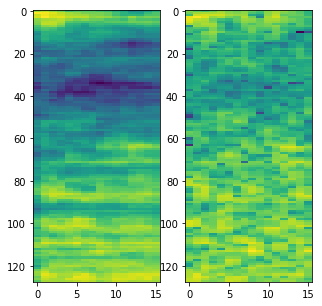

In [14]:

for images, labels in train_dl: 
    print("spectrogram shape: ", images.shape)
    out = autoencoder(images)
    print("output shape: ", out.shape)
    break 
    
img = out[1][0].detach().cpu()
print(img.shape) 
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(1,2,figsize = (5,5))
axs[0].imshow(img, aspect = 'auto')
axs[1].imshow(images[1][0].detach().cpu(), aspect = 'auto')

In [15]:
out_list = [[] for i in range(3)]
imgs = [[] for i in range(3)]
mse_per_image = nn.MSELoss(reduction='none')
for images, labels in test_dl:
    print(images.shape)
    out = autoencoder(images)
    losses = torch.sum(mse_per_image(images, out).detach().cpu(), dim =(1,2,3))/(images.shape[-1]*images.shape[-2])
    losses = losses.numpy()
    for i in range(len(images)):
        out_list[int(labels[i].detach().cpu())].append(losses[i])
        imgs[int(labels[i].detach().cpu())].append(images[i])


torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])


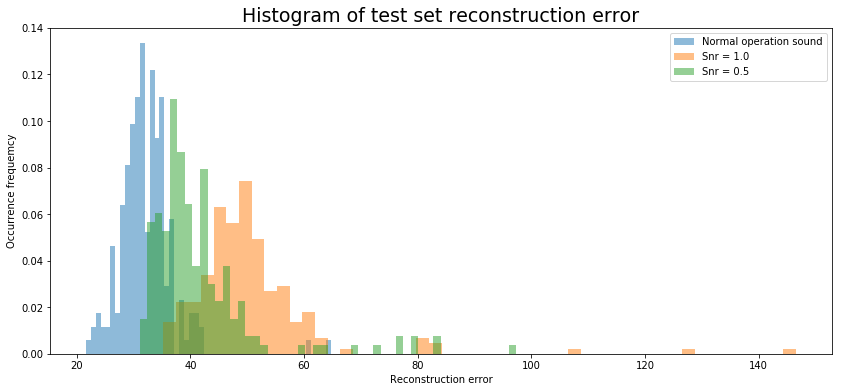

torch.Size([1, 128, 16])


In [16]:

fig, ax = plt.subplots(1,1,figsize = (14,6))

ax.title.set_text("Histogram of test set reconstruction error")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Snr = 1.0", "Snr = 0.5"]

for i in range(len(out_list)):
    ax.hist(bins = 50, x=out_list[i], alpha = 0.5, label = labels[i], density = True)

ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Occurrence frequemcy")
ax.legend()
plt.show()

min_img = imgs[1][out_list[1].index(min(out_list[1]))]
print(np.shape(min_img))


torch.Size([1, 128, 16])
torch.Size([128, 16])


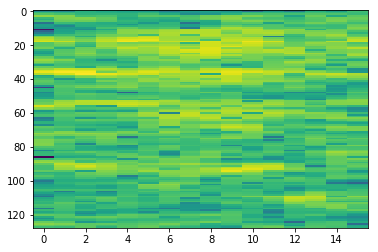

In [17]:
min_img = imgs[1][out_list[1].index(min(out_list[1]))]
print(np.shape(min_img))
im = min_img.detach().cpu().squeeze()
print(np.shape(im))
plt.imshow(im, aspect = "auto")

The difference is 0.14123234951053987


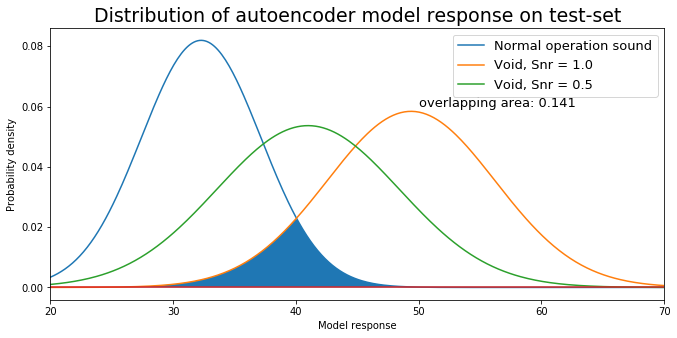

In [18]:
import scipy.integrate
from scipy.stats import norm
fig, ax = plt.subplots(1,1,figsize = (11,5))
integrate = scipy.integrate.quad
ax.title.set_text("Distribution of autoencoder model response on test-set")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Void, Snr = 1.0", "Void, Snr = 0.5"]
x = np.linspace(20,140,800)
SMALL_SIZE = 13
MEDIUM_SIZE = 13
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
 
for i in range(len(out_list)):
    truncated = [out_list[i][j] if out_list[i][j]<=65 else 65 for j in range(len(out_list[i]))]
    if i ==1: 
        m_old = m
        s_old = s
        y_old = y
    m = np.mean(truncated)
    s = np.sqrt(np.var(truncated))
    y = norm.pdf(x,m,s)

    if i==1:
        under_fun = lambda x: min(norm.pdf(x,m,s), norm.pdf(x,m_old, s_old))
        diff = integrate(under_fun, 10,60)
        print(f"The difference is {diff[0]}")
        y_min = [min(y[i],y_old[i]) for i in range(len(y))]
        ax.fill_between(x, y_min)
    ax.plot(x,y, label = labels[i])
    


ax.plot(x, [0 for i in range(len(x))])
ax.set_xlim([20,70])
ax.set_xlabel("Model response")
ax.set_ylabel("Probability density")
ax.text(50,0.06,f"overlapping area: {diff[0]:.3f}")
ax.legend()
plt.show()


The aoc score is 0.984 for snr =1
The aoc score is 0.900 for snr =0.5


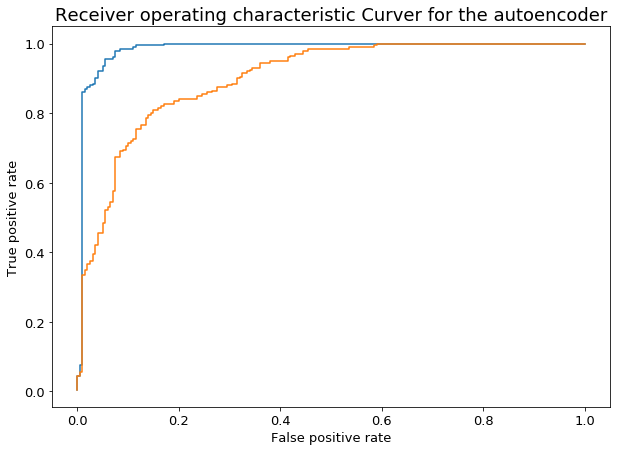

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pickle 
scores1 = out_list[0]+out_list[1]
y1 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[1]))]
fpr1, tpr1, thresholds1 = roc_curve(y1, scores1, pos_label = 1)

aoc_snr1 = roc_auc_score(y1,scores1)
print(f"The aoc score is {aoc_snr1:.3f} for snr =1")

scores2 = out_list[0]+out_list[2]
y2 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[2]))]
fpr2, tpr2, thresholds2= roc_curve(y2, scores2, pos_label = 1)

aoc_snr2 = roc_auc_score(y2,scores2)
print(f"The aoc score is {aoc_snr2:.3f} for snr =0.5")

with open("auto_roc.txt", "wb") as f: 
    pickle.dump({"fpr1":fpr1, "tpr1":tpr1, "thresholds1":thresholds1,"fpr2":fpr2, "tpr2":tpr2, "thresholds2":thresholds2
                , "scores1": scores1, "scores2": scores2, "y1": y1, "y2":y2},f)

fig, ax = plt.subplots(1,1, figsize = (10,7))

ax.title.set_text("Receiver operating characteristic Curver for the autoencoder")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.plot(fpr1, tpr1)
ax.plot(fpr2, tpr2)

In [20]:
import librosa

test_piece, sr = librosa.load("./data/synthetic/7_with_void.wav")

score = []
i =0 
my_len = 16*512-1
while i<len(test_piece)-my_len:
    piece = test_piece[i:i+my_len]
    xt  = librosa.power_to_db(librosa.feature.melspectrogram(piece, n_mels = 128, fmax = 1024))
    xt = torch.tensor(xt).float()
    xt = torch.unsqueeze(xt,0)
    xt = torch.unsqueeze(xt,0)
    xt = xt.to(device)
    recons = autoencoder(xt)
    loss = mse_per_image(recons, xt)
    
    score.append(float(torch.sum(loss.detach().cpu())/(xt.shape[-1]*xt.shape[-2])))
    i+= 512
    


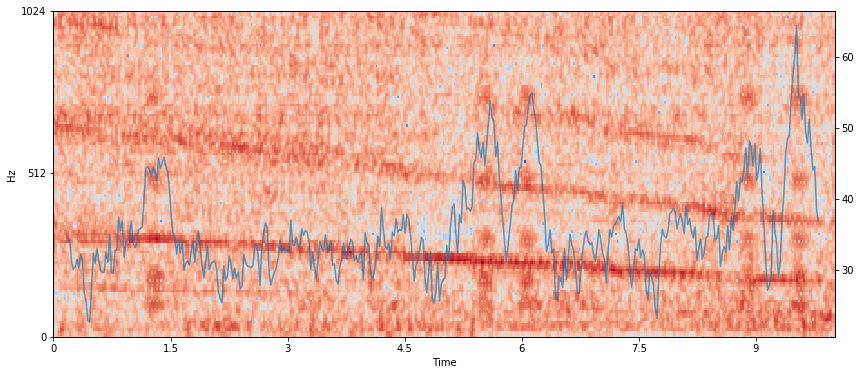

In [157]:
import librosa.display
x =[]
test_xt = librosa.power_to_db(librosa.feature.melspectrogram(test_piece, n_mels =128, fmax= 1024))
fig = plt.gcf()
fig.set_size_inches(14,6)
ax = plt.subplot()

ax2 = ax.twinx()
librosa.display.specshow(test_xt, fmax = 1024, y_axis = "mel", ax = ax, x_axis = 'time')
for i in range(len(score)):
    x.append((i+8)*(512/sr))
ax2.plot(x,score, alpha = 0.7)

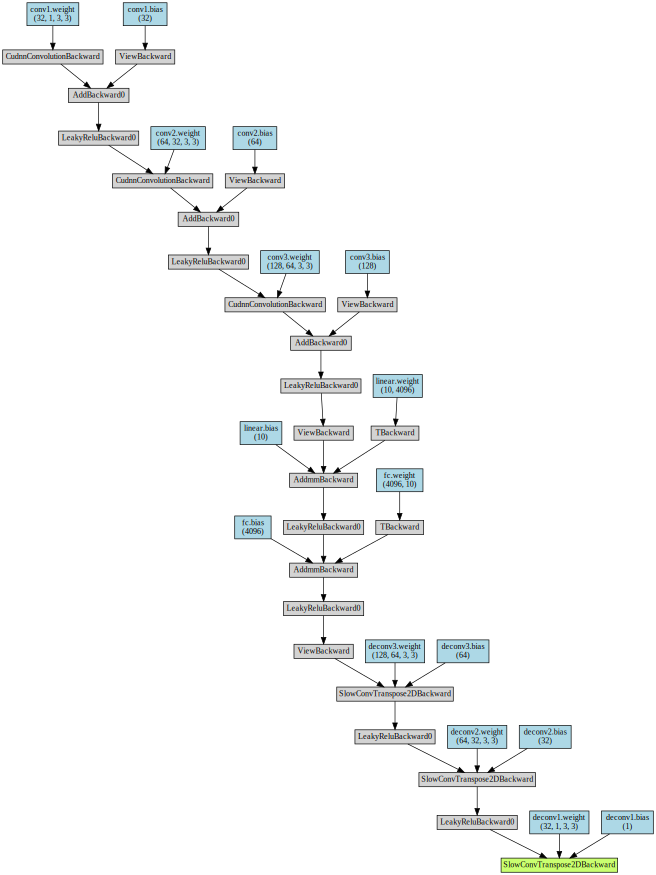

In [161]:
from torchviz import make_dot 
make_dot(recons, params = dict(autoencoder.named_parameters()))

In [163]:
from torch.utils.tensorboard import SummaryWriter 
writer = SummaryWriter("runs/ae_experiment_1")

In [169]:
writer.add_graph(autoencoder,images)
